# Time Diagrams

Tasks:

- plot rotation angle $\theta$ and rotation speed $\dot \theta$ against time
    - $\theta$ is measured both with sensor fusion (Oscillation in the AndroSensor app) and calculated from the magnometer readings
    - the rotation speed is measured with the gyroscope 
- fit the data to the equations of motion of a damped harmonic oscillator
- from the parameters obtained, determin the quality factor $Q_{f}$

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit

In [3]:
def shift(arr, shift):
    """ Function to constrain the measurements in degrees inside a 0-360 range
    (it basically avoid the visual effect we get due to the arbitrary assignment 
    of 0 and 360 in the app)
    """
    res = []
    for v in arr:
        v += shift
        if v > 360:
            v -= 360
        if v < 0:
            v = 360 - abs(v)
        res.append(v)
    return np.array(res)

def time_to_rad(arr):
    """ Convert time values to radiants with a conversion: n_rad = t*step_rad*pi/step_time
        Time is in [ms]
    """
    step_rad = 0.5
    step_time = 10000
    return arr*step_rad*np.pi/step_time

def shift_min_to_zero(arr):
    shift = np.amin(arr)
    return arr - shift

In [22]:
def general_damped_sinusoid(t, amp, dec, ang_freq, phase, shift):
    return amp * np.exp(-dec*t) * (np.cos(ang_freq*t+phase)+np.sin(ang_freq*t+phase)) + shift

In [8]:
# Remember to delete first row from the file
input_file = "data/1_surface.csv"

In [9]:
dataset = pd.read_csv(input_file, sep=";")

### Sensor Fusion

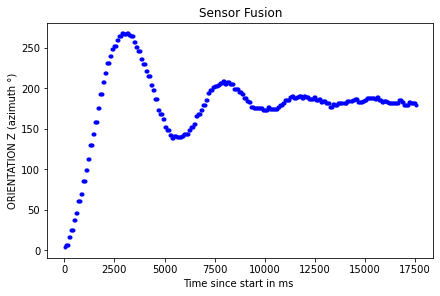

In [10]:
# Plot the result
t = dataset['Time since start in ms ']

dataset['orientation_z_shift'] = shift(dataset['ORIENTATION Z (azimuth °)'], -100)
degrees = dataset['orientation_z_shift']

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Sensor Fusion')
ax.set_xlabel('Time since start in ms ')
ax.set_ylabel('ORIENTATION Z (azimuth °)')
plt.plot(t, degrees, marker='.', linestyle='', color='b')
plt.show();

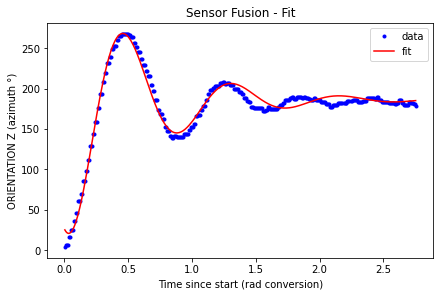

Parameters - amplitude :126.67111342114939, decay constant: 1.6487407567292955, angular frequency: 7.418224622980981, phase: -2.8262211479391373, shift: 186.17595233011014
Quality factor: 4.499327497487811


In [23]:
# Perform fit

dataset['time_in_rad'] = time_to_rad(dataset['Time since start in ms '])
rad_t = dataset['time_in_rad']

# Fit only between 0 and 1.5 rad
rad_t_range = dataset['time_in_rad'][dataset['time_in_rad'] < 2.]
degrees_range = dataset['orientation_z_shift'][dataset['time_in_rad'] < 2.]

popt, pcov = curve_fit(general_damped_sinusoid, rad_t_range, degrees_range, maxfev=100000)
amp, dec, ang_freq, phase, sh = popt
stdevm = np.sqrt(np.diag(pcov))

pred_degrees = general_damped_sinusoid(rad_t, amp, dec, ang_freq, phase, sh)

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Sensor Fusion - Fit')
ax.set_xlabel('Time since start (rad conversion)')
ax.set_ylabel('ORIENTATION Z (azimuth °)')
plt.plot(rad_t, degrees, marker='.', linestyle='', color='b', label='data')
plt.plot(rad_t, pred_degrees, color='r', label='fit')
plt.legend()
plt.show();

print("Parameters - amplitude :{}, decay constant: {}, angular frequency: {}, phase: {}, shift: {}".format(
    amp, dec, ang_freq, phase, sh)
     )
print("Quality factor: {}".format(ang_freq/dec))

### Magnetometer

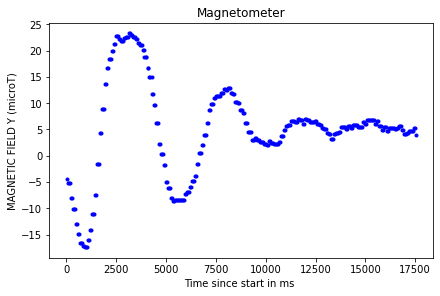

In [24]:
# Plot the result
mag_field = dataset['MAGNETIC FIELD Y (μT)']

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Magnetometer')
ax.set_xlabel('Time since start in ms ')
ax.set_ylabel('MAGNETIC FIELD Y (microT)')
plt.plot(t, mag_field, marker='.', linestyle='', color='b')
plt.show();

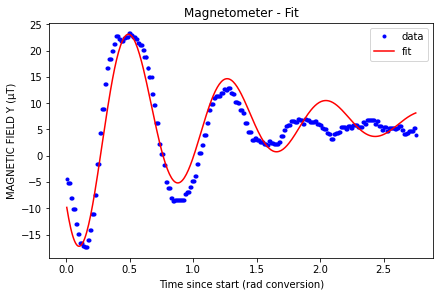

Parameters - amplitude :18.51678208708809, decay constant: 0.9132403713530524, angular frequency: 8.081777761993022, phase: -3.2838122261806633, shift: 6.4904634611764305
Quality factor: 8.849562519908204


In [28]:
# Perform fit

# Fit only between 0 and 1.5 rad
rad_t_range = dataset['time_in_rad'][dataset['time_in_rad'] < 2.]
mag_field_range = dataset['MAGNETIC FIELD Y (μT)'][dataset['time_in_rad'] < 2.]

popt, pcov = curve_fit(general_damped_sinusoid, rad_t_range, mag_field_range, maxfev=100000)
amp, dec, ang_freq, phase, sh = popt
stdevm = np.sqrt(np.diag(pcov))

pred_mag_field = general_damped_sinusoid(rad_t, amp, dec, ang_freq, phase, sh)

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Magnetometer - Fit')
ax.set_xlabel('Time since start (rad conversion)')
ax.set_ylabel('MAGNETIC FIELD Y (μT)')
plt.plot(rad_t, mag_field, marker='.', linestyle='', color='b', label='data')
plt.plot(rad_t, pred_mag_field, color='r', label='fit')
plt.legend()
plt.show();

print("Parameters - amplitude :{}, decay constant: {}, angular frequency: {}, phase: {}, shift: {}".format(
    amp, dec, ang_freq, phase, sh)
     )
print("Quality factor: {}".format(ang_freq/dec))

### Gyroscope

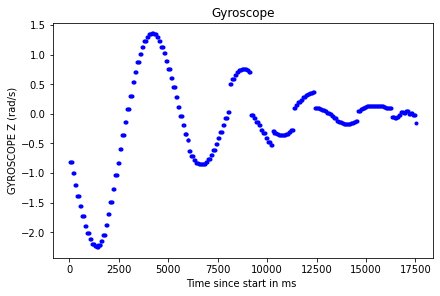

In [29]:
# Plot the result
rad_vel = dataset['GYROSCOPE Z (rad/s)']

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Gyroscope')
ax.set_xlabel('Time since start in ms ')
ax.set_ylabel('GYROSCOPE Z (rad/s)')
plt.plot(t, rad_vel, marker='.', linestyle='', color='b')
plt.show();

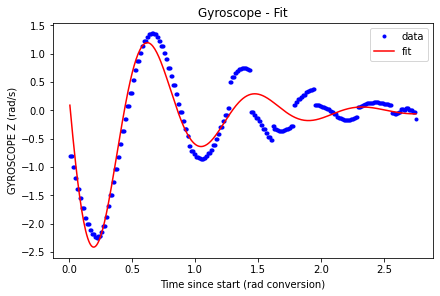

Parameters - amplitude :-2.3520327858808754, decay constant: 1.5885554340918062, angular frequency: 7.36670869488721, phase: -0.8493719623540853, shift: -0.022477097742630698
Quality factor: 4.637363315620669


In [30]:
# Perform fit

# Fit only between 0 and 1.5 rad
rad_t_range = dataset['time_in_rad'][dataset['time_in_rad'] < 2.]
rad_vel_range = dataset['GYROSCOPE Z (rad/s)'][dataset['time_in_rad'] < 2.]

popt, pcov = curve_fit(general_damped_sinusoid, rad_t_range, rad_vel_range, maxfev=1000000)
amp, dec, ang_freq, phase, sh = popt
stdevm = np.sqrt(np.diag(pcov))

pred_rad_vel = general_damped_sinusoid(rad_t, amp, dec, ang_freq, phase, sh)

fig, ax = plt.subplots(constrained_layout=True)
ax.set_title('Gyroscope - Fit')
ax.set_xlabel('Time since start (rad conversion)')
ax.set_ylabel('GYROSCOPE Z (rad/s)')
plt.plot(rad_t, rad_vel, marker='.', linestyle='', color='b', label='data')
plt.plot(rad_t, pred_rad_vel, color='r', label='fit')
plt.legend()
plt.show();

print("Parameters - amplitude :{}, decay constant: {}, angular frequency: {}, phase: {}, shift: {}".format(
    amp, dec, ang_freq, phase, sh)
     )
print("Quality factor: {}".format(ang_freq/dec))